In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
h5py.enable_ipython_completer()

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
import ATARI.atari_io.hdf5 as io
from ATARI.theory.xs import SLBW


In [2]:
%matplotlib widget

<ErrorbarContainer object of 3 artists>

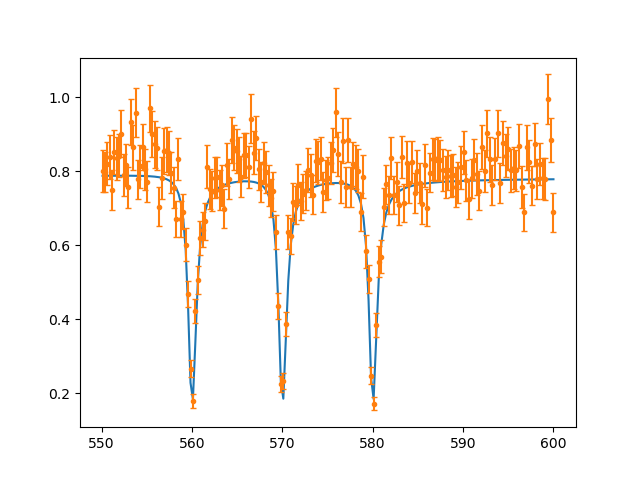

In [211]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


# resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
resonance_ladder = pd.DataFrame({'E':[570, 560, 580], 'J':[3.0,3.0,3.0], 'chs':[1.0,1.0,1.0], 'lwave':[0.0,0.0,0.0], 'J_ID':[1.0,1.0,1.0], 'gnx2':[100,100,100], 'Gg':[750,750,750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

from ATARI.utils.datacontainer import DataContainer
from ATARI.theory.experimental import trans_2_xs

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

max_xs, _ = trans_2_xs(threshold_0T, dc.n)

figure()
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
plot(dc.pw_exp.E, dc.pw_exp.theo_trans)
errorbar(dc.pw_exp.E, dc.pw_exp.exp_trans, yerr=dc.pw_exp.exp_trans_unc, fmt='.', capsize=2)
# ylim([-5, max_xs*1.25])

In [212]:
# val,vec = np.linalg.eig(exp.CovT)
# figure()
# plot(np.log10(np.sort(val)), '.')

In [213]:
from ATARI.utils.stats import chi2_val
from scipy.stats import chi2
from scipy.stats import ks_1samp
from scipy.stats import goodness_of_fit
from scipy import stats 

### Generate/save the data

In [214]:


# chi2vals = []
# stdres = []
trans = np.zeros([5000, len(exp.trans.E)])
trans_unc = np.zeros([5000, len(exp.trans.E)])
crossec = np.zeros([5000, len(exp.trans.E)])
crossec_unc = np.zeros([5000, len(exp.trans.E)])

isamples = 5000
for i in range(isamples):
    exp.run(df_true)
    # chi2vals.extend(chi2_val(exp.trans.exp_trans, exp.theo.theo_trans, exp.CovT).flatten())
    # stdres.extend((exp.trans.exp_trans-exp.theo.theo_trans)/exp.trans.exp_trans_unc)
    trans[i, :] = exp.trans.exp_trans
    trans_unc[i, :] = exp.trans.exp_trans_unc
    xs, cov = trans_2_xs(exp.trans.exp_trans, dc.n, CovT = exp.CovT)
    crossec[i, :] = xs
    crossec_unc[i, :] = np.sqrt(np.diag(cov))
    
# np.save('chi2vals_3resfat_5ksamp.npy', chi2vals)
np.save('trans_3resfat_5ksamp.npy', trans)
np.save('trans_unc_3resfat_5ksamp.npy', trans_unc)
np.save('crossec_3resfat_5ksamp.npy', crossec)
np.save('crossec_unc_3resfat_5ksamp.npy', crossec_unc)


KeyboardInterrupt: 

### investigate noise distributions

In [215]:
trans = np.load('trans_3resfat_5ksamp.npy' )
trans_unc = np.load('trans_unc_3resfat_5ksamp.npy' )
crossec = np.load('crossec_3resfat_5ksamp.npy' )
crossec_unc = np.load('crossec_unc_3resfat_5ksamp.npy' )

In [216]:
def calc_res(true, dat, unc):
    residuals = dat-np.repeat(np.array([true]), 5000, axis=0)
    normed_residuals = residuals/unc
    return residuals, normed_residuals

residuals, normed_residuals = calc_res(df_true.theo_trans, trans, trans_unc)
# residuals, normed_residuals = calc_res(true, crossec, crossec_unc)

### rotate unnormalized residuals to make them independent before normality test

115.34924371322268
[0.576 0.656 0.787 0.918 1.092]
1.3171552587847615e-42
ShapiroResult(statistic=0.9967727661132812, pvalue=4.203895392974451e-45)


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


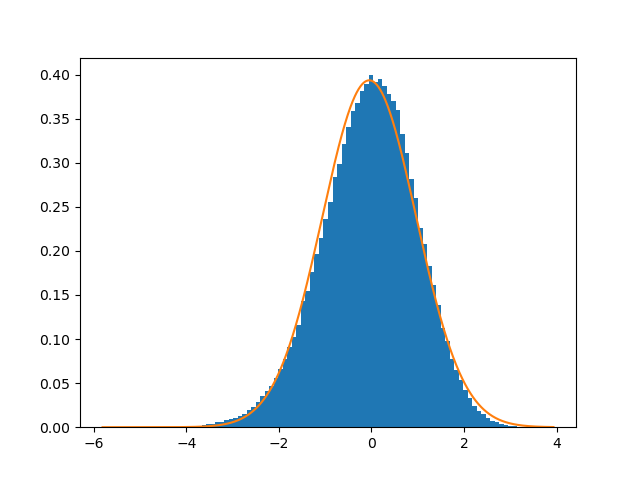

In [217]:
# obj = residuals.flatten()
obj = normed_residuals[0:1000,:].flatten()

figure()

bins = hist(obj, bins =100, density=True)
x = np.linspace(min(obj), max(obj), 1000)
plot(x , stats.norm.pdf(x, loc=np.mean(obj), scale=np.std(obj)))

# stat tests
ares = stats.anderson(obj, dist='norm')
ksres = stats.kstest( obj, stats.norm(loc=np.mean(obj), scale=np.std(obj)).cdf)  #stats.norm.cdf)
sres = stats.shapiro( obj )
print(ares.statistic)
print(ares.critical_values)
print(ksres.pvalue)
print(sres)
# print() 

<bound method rv_frozen.cdf of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f871dc06e80>>

### Fit Chi2 distribution to chi2 values from syndat data

(243.2067937007737, -58.81557411209137, 1)
DOF Dist: 243.2067937007737
181
KstestResult(statistic=0.01594353357986611, pvalue=0.1556808221103998, statistic_location=185.61177681065516, statistic_sign=1)


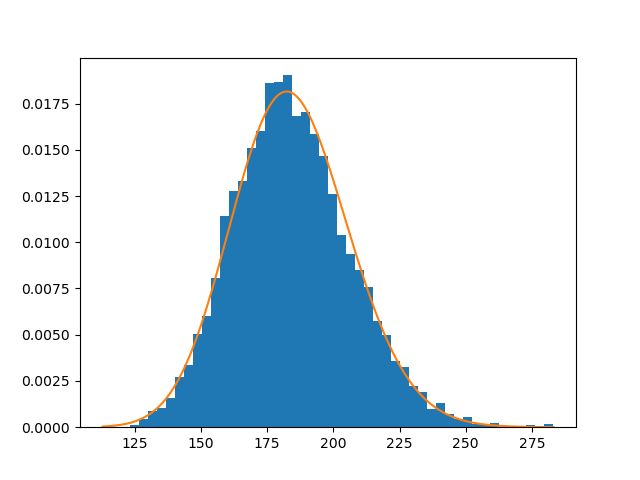

In [220]:


numres = 3
chi2vals = np.load(f'chi2vals_{numres}resfat_5ksamp.npy')

fitted_params = chi2.fit(chi2vals,fscale=1) #, floc=0, fscale=1)
print(fitted_params)
df = fitted_params[0]
print(f'DOF Dist: {df}')
# print(f'DOF Res: {(df-len(exp.trans.E))/numres}')
print(len(exp.trans.E))



print(ks_1samp(chi2vals, chi2(df, loc=fitted_params[1],scale=fitted_params[2]).cdf))

figure()
bins = hist(chi2vals, bins=50, density=True)
x = np.linspace(min(chi2vals),max(chi2vals),1000)
plot(x, chi2.pdf(x, df, loc=fitted_params[1],scale=fitted_params[2]))


### Test simple model

DOF Dist: 181.17343750000026
181
KstestResult(statistic=0.016291800347680074, pvalue=0.13913406022369113, statistic_location=195.28498376416962, statistic_sign=-1)


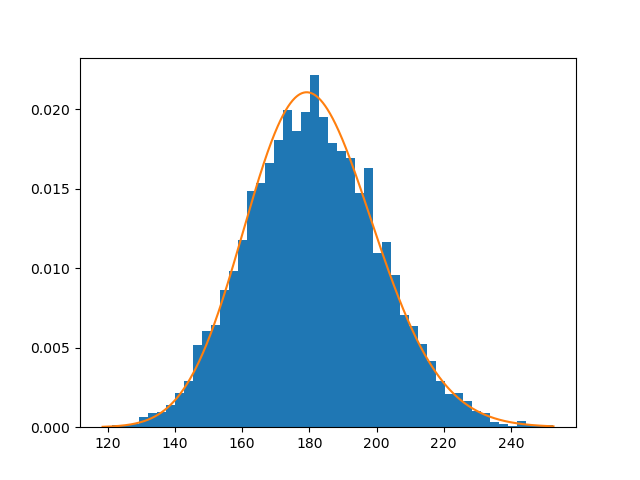

In [202]:
# resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)

# true
# cov = np.diag(true/10)
cov = exp.CovT
samples = np.random.default_rng().multivariate_normal(true, cov, size=5000)

chi2vals = []
for sample in samples:
    chi2vals.extend(chi2_val(sample, true, cov).flatten())

fitted_params = chi2.fit(chi2vals, floc=0, fscale=1)
df = fitted_params[0]
print(f'DOF Dist: {df}')
print(len(exp.trans.E))

print(ks_1samp(chi2vals, chi2(df, loc=fitted_params[1],scale=fitted_params[2]).cdf))

figure()
bins = hist(chi2vals, bins=50, density=True)
x = np.linspace(min(chi2vals)+0.01,max(chi2vals),1000)
plot(x, chi2.pdf(x, df, loc=fitted_params[1],scale=fitted_params[2]))
